In [1]:
# Importe de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier

In [231]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [232]:
# Input variables:
#    # bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
#                                        "blue-collar","self-employed","retired","technician","services") 
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric) 
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")
#    # related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)
#    # other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#   Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [233]:
display(df.head(5))
display(df.dtypes)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [12]:
target_col = "y"
num_cols = ["age","balance","day","duration","campaign","pdays","previous"
]

cat_cols = [
"job","marital","education","default","housing","loan","contact","month","poutcome"
]

In [2]:
# Se crea esta función para validar que los datos que se recibiran a 
# futuro, están en linea con las variables de entreno o de estudio, asi mismo si existen nulos o no, y si es así revisar los casos puntales 
# Se transforma la variable Y categorica a numerical, se puede hacer porque es una variable ordinal
def validacion(data_frame,numerical_col,categorical_cols):
    data_frame["y"] = (data_frame["y"].astype(str).str.lower() == "yes").astype(int)
    required = set([target_col] + numerical_col + categorical_cols)
    if required != set(data_frame.columns):
        faltante = set(data_frame.columns).difference(required)
        sobrante = required.difference(set(data_frame.columns))
        raise ValueError(f"Col faltante: {faltante} , col sobrantes {sobrante}")
    else:
        print("Columnas coinciden: OK")

        
    nulos = data_frame.isnull().sum()
    columnas_con_nulos = nulos[nulos > 0]

    if not columnas_con_nulos.empty:
        raise ValueError(f"Col null: (columnas_con_nulos)")
    else:
        print("No existen columnas con Null: OK")


In [3]:
validacion(df,num_cols,cat_cols)

NameError: name 'df' is not defined

In [14]:
def plot_numeric_kde(dataframe, target="y"):
    n_cols = 3
    num_cols = dataframe.select_dtypes(include=['int64','float64']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.kdeplot(
            data=dataframe,
            x=col,
            hue=target,
            common_norm=False,
            fill=True,
            alpha=0.4,
            ax=axes[i]
        )
        axes[i].set_title(f"Distribución de {col} según {target}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Densidad")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [5]:
def plot_categorical_distribution(dataframe, target="y", n_cols=3, month_order=None):

    cat_cols = dataframe.select_dtypes(include=['object','category','bool']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    n_rows = int(np.ceil(len(cat_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        dist = (
            dataframe.groupby([col, target])
              .size()
              .reset_index(name="count")
        )
        dist["pct"] = dist.groupby(col)["count"].transform(lambda x: x / x.sum())
        
        # Manejar orden de meses
        if month_order is not None and col == "month":
            dist["month"] = pd.Categorical(dist["month"], categories=month_order, ordered=True)
            x_order = month_order
        else:
            x_order = None

        sns.barplot(
            data=dist,
            x=col,
            y="pct",
            hue=target,
            order=x_order,
            ax=axes[i]
        )
        axes[i].set_title(f"Distribución de {target} por {col}")
        axes[i].set_ylabel("Proporción")
        axes[i].tick_params(axis='x', rotation=45)

    # Eliminar subplots vacíos si los hay
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [6]:
def percent_box(data_frame):
    num_df = data_frame.select_dtypes(include=np.number)
    cols = num_df.columns
    n_cols = 3
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.violinplot(y=data_frame[col], ax=axes[i], inner=None, color="lightgray")
        sns.boxplot(y=data_frame[col], ax=axes[i], width=0.2, color="skyblue")
        axes[i].set_title(f"{col}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    
    return plt.show()

In [7]:
def resumen_por_categoria(data_frame, cat_cols, target='y'):
    for col in cat_cols:
        t = (
            data_frame
            .groupby(col)[target]
            .agg(
                y_1=lambda x: (x == 1).sum(),
                y_0=lambda x: (x == 0).sum(),
                total='size',
                rate='mean'
            )
            .sort_values('rate', ascending=False)
        )
        display(t)


In [254]:
resumen_por_categoria(df,CAT_COLS)

,y_1,y_0,total,rate
job,,,,
student,269,669,938,0.287
retired,516,1748,2264,0.228
unemployed,202,1101,1303,0.155
management,1301,8157,9458,0.138
admin.,631,4540,5171,0.122
self-employed,187,1392,1579,0.118
unknown,34,254,288,0.118
technician,840,6757,7597,0.111
services,369,3785,4154,0.089


,y_1,y_0,total,rate
marital,,,,
single,1912,10878,12790,0.149
divorced,622,4585,5207,0.119
married,2755,24459,27214,0.101


,y_1,y_0,total,rate
education,,,,
tertiary,1996,11305,13301,0.150
unknown,252,1605,1857,0.136
secondary,2450,20752,23202,0.106
primary,591,6260,6851,0.086


,y_1,y_0,total,rate
default,,,,
no,5237,39159,44396,0.118
yes,52,763,815,0.064


,y_1,y_0,total,rate
housing,,,,
no,3354,16727,20081,0.167
yes,1935,23195,25130,0.077


,y_1,y_0,total,rate
loan,,,,
no,4805,33162,37967,0.127
yes,484,6760,7244,0.067


,y_1,y_0,total,rate
contact,,,,
cellular,4369,24916,29285,0.149
telephone,390,2516,2906,0.134
unknown,530,12490,13020,0.041


,y_1,y_0,total,rate
month,,,,
mar,248,229,477,0.520
dec,100,114,214,0.467
sep,269,310,579,0.465
oct,323,415,738,0.438
apr,577,2355,2932,0.197
feb,441,2208,2649,0.166
aug,688,5559,6247,0.110
jun,546,4795,5341,0.102
nov,403,3567,3970,0.102


,y_1,y_0,total,rate
poutcome,,,,
success,978,533,1511,0.647
other,307,1533,1840,0.167
failure,618,4283,4901,0.126
unknown,3386,33573,36959,0.092


In [237]:
validacion(df)

Columnas coinciden: OK
No existen columnas con Null: OK


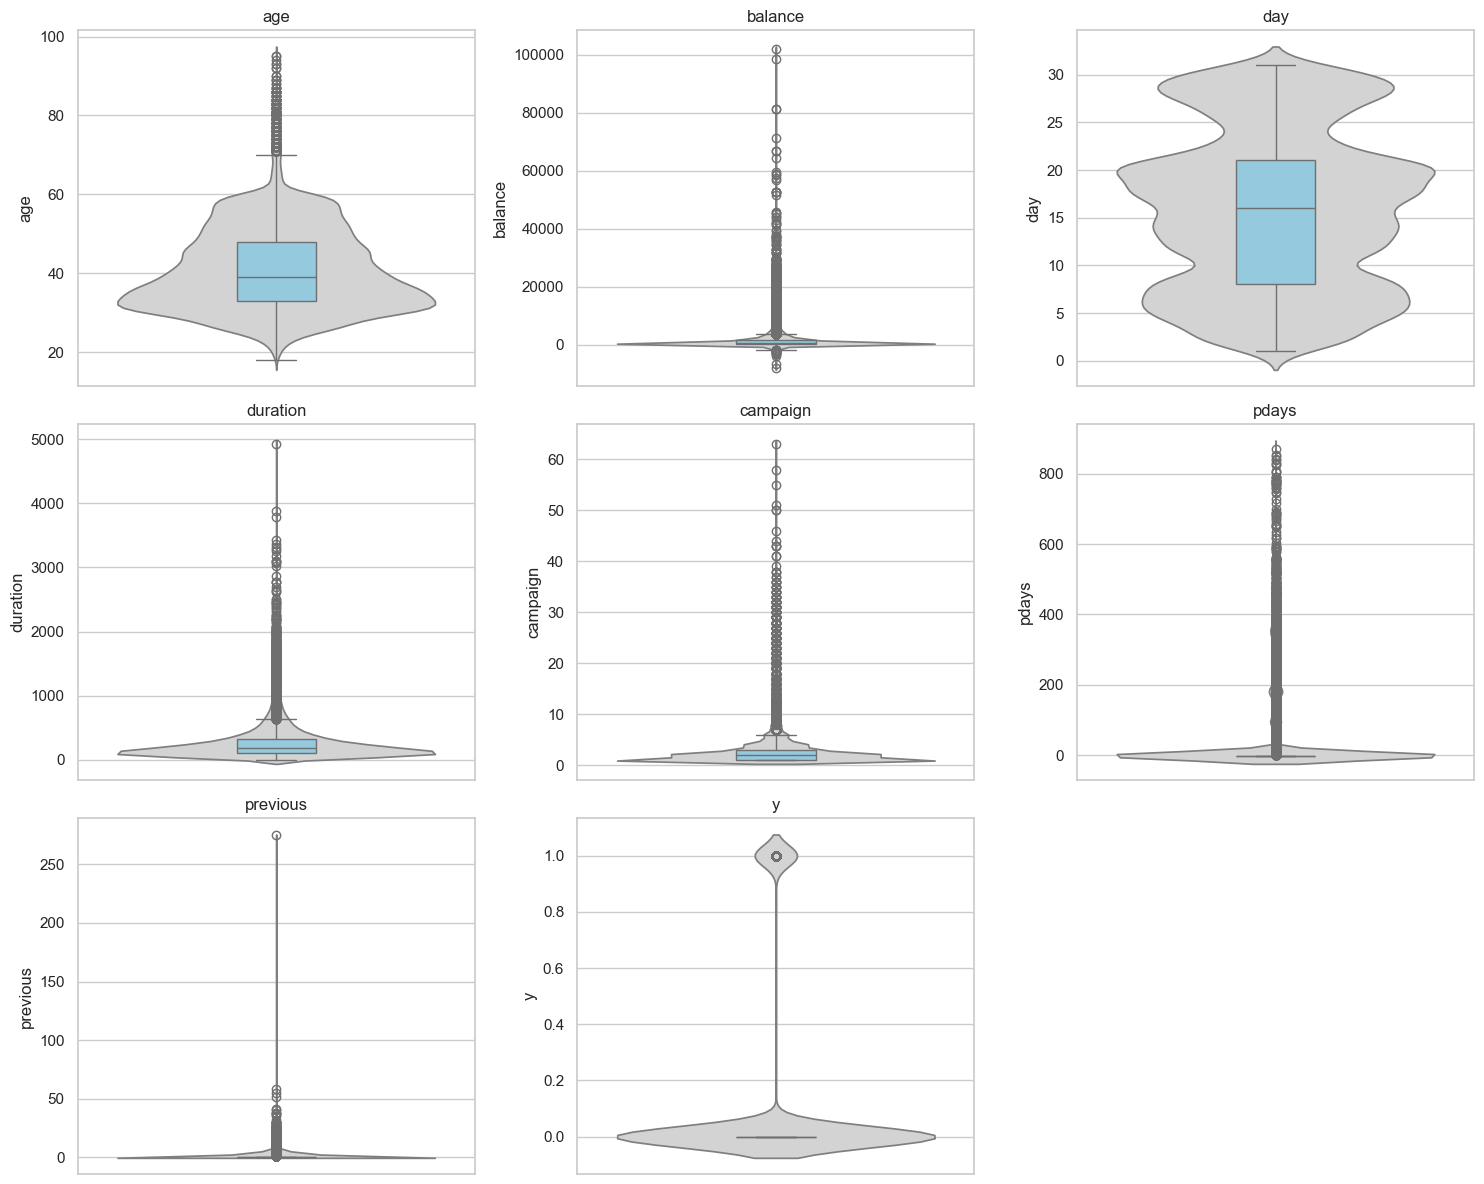

In [239]:
percent_box(df)

In [223]:
tot_promedio = df['y'].mean()

In [224]:
tot_promedio

np.float64(0.0)

In [17]:
X = df.drop(columns=['y'])
y = df[["y"]]


In [19]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


In [40]:
df_X.head(5)

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [49]:
feature_cols = [c for c in df.columns if c not in ['y']]
X = df[feature_cols].copy()
y = df['y'].values

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
])

logit = LogisticRegression(max_iter=2000, class_weight= 'balanced')

pipe = Pipeline([('pre', pre), ('clf', logit)])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_cv = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba')[:,1]

auc = roc_auc_score(y, proba_cv)
ap = average_precision_score(y, proba_cv)

auc, ap

(0.9095331898336185, 0.5446236789196289)

In [20]:
def train_logit_cv_with_coefs(df, target='y', n_splits=5, random_state=42):

    feature_cols = [c for c in df.columns if c != target]
    X = df[feature_cols].copy()
    y = df[target].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])

    logit = LogisticRegression(
        max_iter=2000,
        class_weight='balanced'
    )

    pipe = Pipeline([
        ('pre', pre),
        ('clf', logit)
    ])

    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    proba_cv = cross_val_predict(
        pipe, X, y, cv=cv, method='predict_proba'
    )[:, 1]

    auc = roc_auc_score(y, proba_cv)

    pipe.fit(X, y)
    feature_names = pipe.named_steps['pre'].get_feature_names_out()
    coefs = pipe.named_steps['clf'].coef_.ravel()
    coef_df = (
        pd.DataFrame({
            'feature': feature_names,
            'coef': coefs,
            'odds_ratio': np.exp(coefs)
        })
        .sort_values('odds_ratio', ascending=False)
        .reset_index(drop=True)
    )

    return {
        'auc': auc,
        'coef_df': coef_df,
        'pipeline': pipe
    }


In [ ]:

pre_xgb = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
])

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

pipe_xgb = Pipeline([
    ('pre', pre_xgb),
    ('clf', xgb)
])


In [ ]:


proba_xgb = cross_val_predict(
    pipe_xgb,
    X,
    y,
    cv=cv,
    method='predict_proba'
)[:, 1]

auc_xgb = roc_auc_score(y, proba_xgb)
ap_xgb  = average_precision_score(y, proba_xgb)

auc_xgb, ap_xgb


(0.93507331023611, 0.6300814637363884)

In [56]:
pipe_xgb.fit(X, y)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
X_enc = pipe_xgb.named_steps['pre'].transform(X)

# nombres de features
ohe = pipe_xgb.named_steps['pre'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_features)


In [58]:
import shap

explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])
shap_values = explainer.shap_values(X_enc)


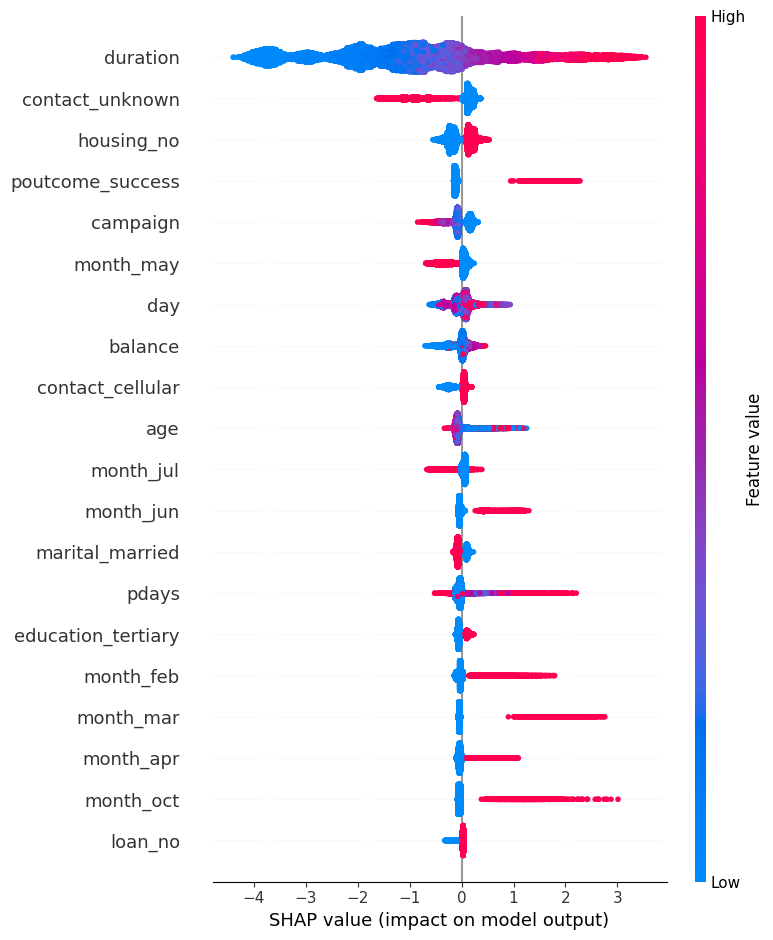

In [62]:
shap.summary_plot(
    shap_values,
    X_enc,
    feature_names=feature_names,
    sort= True,
    show=True
)


In [375]:
y

array([0, 0, 0, ..., 1, 0, 0], shape=(45211,))

In [382]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import shap

def xgb_analysis(df, target_col, xgb_params=None, plot_shap=True):
    """
    Entrena un modelo XGBoost con preprocesamiento automático y genera métricas y gráfico SHAP.
    
    Parámetros:
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    target_col : str
        Nombre de la columna objetivo.
    xgb_params : dict, opcional
        Parámetros para XGBClassifier.
    plot_shap : bool
        Si True, genera el gráfico SHAP summary plot.
    
    Retorna:
    -------
    pipe_xgb : Pipeline
        Pipeline entrenado con preprocesamiento y modelo.
    auc : float
        ROC-AUC promedio en CV.
    ap : float
        Average Precision en CV.
    shap_values : np.array
        Valores SHAP del conjunto de entrenamiento.
    feature_names : list
        Lista de nombres de features tras el preprocesamiento.
    """
    
    # Separar X y y
    
    X = df.drop(columns=target_col)
    y = df[target_col].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    # Preprocesamiento
    pre_xgb = ColumnTransformer([
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])
    
    # Parámetros por defecto del XGBClassifier
    if xgb_params is None:
        xgb_params = {
            'n_estimators': 300,
            'max_depth': 4,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'random_state': 42
        }
    
    xgb_model = XGBClassifier(**xgb_params)
    
    # Pipeline
    pipe_xgb = Pipeline([
        ('pre', pre_xgb),
        ('clf', xgb_model)
    ])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    proba_cv = cross_val_predict(pipe_xgb, X, y, cv=cv, method='predict_proba')[:,1]
    
    auc = roc_auc_score(y, proba_cv)
    ap = average_precision_score(y, proba_cv)
    
    # Entrenar pipeline completo
    pipe_xgb.fit(X, y)
    X_enc = pipe_xgb.named_steps['pre'].transform(X)
    
    # Obtener nombres de features
    ohe = pipe_xgb.named_steps['pre'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_features)
    
    # SHAP
    explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])
    shap_values = explainer.shap_values(X_enc)
    
    if plot_shap:
        shap.summary_plot(shap_values, X_enc, feature_names=feature_names, sort=True, show=True)
    
    return pipe_xgb, auc, ap, shap_values, feature_names


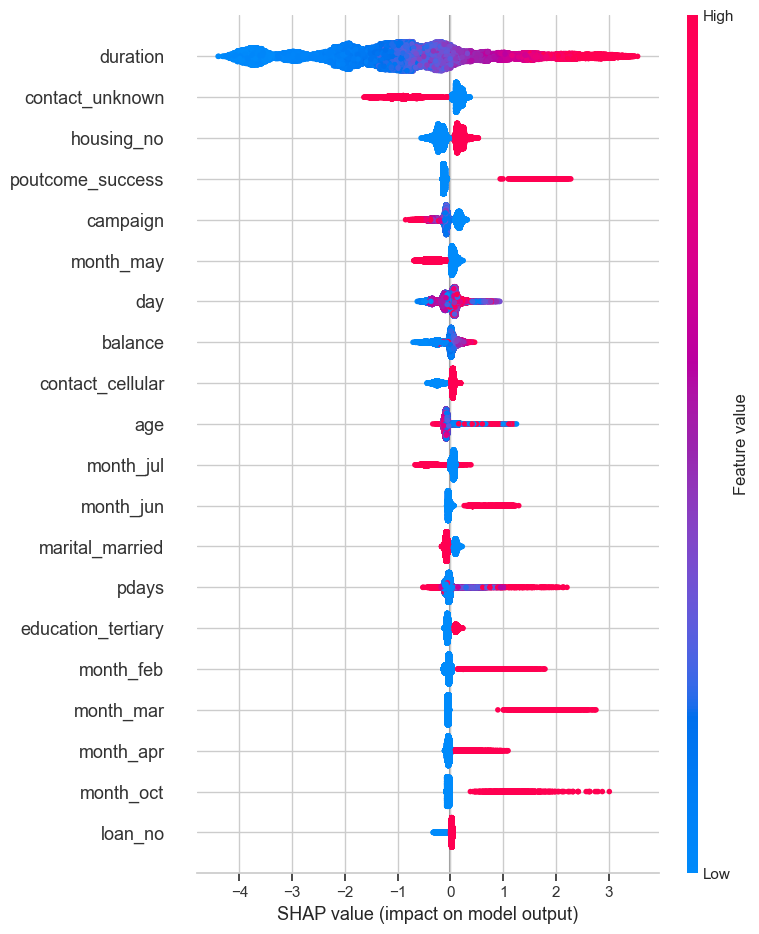

ROC-AUC CV: 0.935
Average Precision CV: 0.630


In [383]:
# Definir columnas y target
target_col = "y"
num_cols = ["age","balance","day","duration","campaign","pdays","previous"]
cat_cols = ["job","marital","education","default","housing","loan","contact","month","poutcome"]

# Ejecutar la función
pipe, auc, ap, shap_vals, feature_names = xgb_analysis(df, target_col)

print(f"ROC-AUC CV: {auc:.3f}")
print(f"Average Precision CV: {ap:.3f}")


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

def compute_oof_predictions(model_pipeline, X, y, cv=None):
    """
    Calcula predicciones fuera de la muestra (OOF) usando cross-validation.
    
    Parámetros:
    ----------
    model_pipeline : sklearn Pipeline
        Pipeline que contiene preprocesamiento y modelo.
    X : pd.DataFrame
        Variables predictoras.
    y : array-like
        Vector objetivo.
    cv : cross-validator, opcional
        Estrategia de cross-validation. Por defecto StratifiedKFold(5).

    Retorna:
    -------
    np.array
        Probabilidades OOF.
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    oof_probs = cross_val_predict(model_pipeline, X, y, cv=cv, method="predict_proba")[:, 1]
    return oof_probs


def simulate_targeting(df, y_col, score_col, top_fractions=(0.1, 0.2, 0.3), n_calls=10000):
    """
    Simula campañas de targeting priorizando a los clientes con mayor score.
    
    Parámetros:
    ----------
    df : pd.DataFrame
        DataFrame con variables predictoras, target y score.
    y_col : str
        Nombre de la columna objetivo.
    score_col : str
        Nombre de la columna de probabilidades o score.
    top_fractions : tuple
        Fracciones superiores a evaluar (ej. 0.1 = top 10%).
    n_calls : int
        Número de contactos simulados.

    Retorna:
    -------
    pd.DataFrame
        Resumen con lift, tasas de conversión y ventas esperadas.
    """
    baseline = df[y_col].mean()
    results = []

    for frac in top_fractions:
        threshold = df[score_col].quantile(1 - frac)
        segment = df[df[score_col] >= threshold].copy()
        segment_rate = segment[y_col].mean()
        lift = segment_rate / baseline if baseline > 0 else np.nan
        expected_if_called = n_calls * segment_rate
        expected_random = n_calls * baseline
        incremental = expected_if_called - expected_random

        results.append({
            "segment": f"Top {int(frac*100)}%",
            "threshold_score": threshold,
            "segment_size": len(segment),
            "baseline_rate": baseline,
            "segment_rate": segment_rate,
            "lift_x": lift,
            "expected_sales_if_call_n": expected_if_called,
            "expected_sales_random_n": expected_random,
            "incremental_sales_n": incremental
        })

    return pd.DataFrame(results).sort_values("segment")



feature_cols = [c for c in df.columns if c != "y"]
X = df[feature_cols].copy()
y = df["y"].values

# Calcular OOF predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df["score_oof"] = compute_oof_predictions(pipe, X, y, cv=cv)

# Métricas de desempeño
auc = roc_auc_score(y, df["score_oof"])
ap = average_precision_score(y, df["score_oof"])
print(f"AUC (OOF): {auc:.3f} | Average Precision (OOF): {ap:.3f}")

# Simulación de targeting
summary = simulate_targeting(df, y_col="y", score_col="score_oof", top_fractions=(0.10, 0.20, 0.30), n_calls=10000)

# Formato más legible
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
display(summary[[
    "segment",
    "baseline_rate",
    "segment_rate",
    "lift_x",
    "expected_sales_if_call_n",
    "expected_sales_random_n",
    "incremental_sales_n"
]])

# Ejemplo detallado del top 10%
top_10 = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
print(
    f"Baseline: {top_10['baseline_rate']:.1%}. "
    f"Si priorizamos el {top_10['segment']} (score >= {top_10['threshold_score']:.3f}), "
    f"la conversión observada en ese segmento es {top_10['segment_rate']:.1%} "
    f"(lift x{top_10['lift_x']:.2f})."
)


AUC (OOF): 0.935 | Average Precision (OOF): 0.630


,segment,baseline_rate,segment_rate,lift_x,expected_sales_if_call_n,expected_sales_random_n,incremental_sales_n
0,Top 10%,0.117,0.632,5.404,"6,322.424","1,169.848","5,152.576"
1,Top 20%,0.117,0.486,4.153,"4,857.901","1,169.848","3,688.053"
2,Top 30%,0.117,0.369,3.153,"3,688.440","1,169.848","2,518.592"


Baseline: 11.7%. Si priorizamos el Top 10% (score >= 0.440), la conversión observada en ese segmento es 63.2% (lift x5.40).


In [389]:
def add_oof_scores(pipe, X, y, cv=None, score_col="score_oof"):

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    proba_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]
    return proba_oof


def targeting_simulation(df, y_col, score_col, top_fracs=(0.10, 0.20, 0.30), n_calls=10000):

    baseline_rate = df[y_col].mean()

    out = []
    for frac in top_fracs:
        thr = df[score_col].quantile(1 - frac)
        seg = df[df[score_col] >= thr].copy()

        seg_rate = seg[y_col].mean()
        lift_vs_base = seg_rate / baseline_rate if baseline_rate > 0 else np.nan

        expected_sales_if_call = n_calls * seg_rate
        expected_sales_random = n_calls * baseline_rate

        out.append({
            "segment": f"Top {int(frac*100)}%",
            "threshold_score": thr,
            "segment_size": len(seg),
            "baseline_rate": baseline_rate,
            "segment_rate": seg_rate,
            "lift_x": lift_vs_base,
            "expected_sales_if_call_n": expected_sales_if_call,
            "expected_sales_random_n": expected_sales_random,
            "incremental_sales_n": expected_sales_if_call - expected_sales_random
        })

    return pd.DataFrame(out).sort_values("segment")



feature_cols = [c for c in df.columns if c not in ["y"]] 
X = df[feature_cols].copy()
y = df["y"].values 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_oof = add_oof_scores(pipe, X, y, cv=cv, score_col="score_oof")

auc = roc_auc_score(y, proba_oof)
ap = average_precision_score(y, proba_oof)
print(f"AUC(OOF)={auc:.3f} | AP(OOF)={ap:.3f}")

df_sim = df.copy()
df_sim["score_oof"] = proba_oof

summary = targeting_simulation(
    df=df_sim,
    y_col="y",
    score_col="score_oof",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000
)

pd.set_option("display.float_format", lambda v: f"{v:,.3f}")
display(summary[[
    "segment",
    "baseline_rate",
    "segment_rate",
    "lift_x",
    "expected_sales_if_call_n",
    "expected_sales_random_n",
    "incremental_sales_n"
]])

row = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
print(
    f"Baseline={row['baseline_rate']:.1%}. "
    f"Si priorizamos el {row['segment']} (score >= {row['threshold_score']:.3f}), "
    f"la conversión observada en ese segmento es {row['segment_rate']:.1%} "
    f"(lift x{row['lift_x']:.2f})."
)


AUC(OOF)=0.935 | AP(OOF)=0.630


,segment,baseline_rate,segment_rate,lift_x,expected_sales_if_call_n,expected_sales_random_n,incremental_sales_n
0,Top 10%,0.117,0.632,5.404,"6,322.424","1,169.848","5,152.576"
1,Top 20%,0.117,0.486,4.153,"4,857.901","1,169.848","3,688.053"
2,Top 30%,0.117,0.369,3.153,"3,688.440","1,169.848","2,518.592"


Baseline=11.7%. Si priorizamos el Top 10% (score >= 0.440), la conversión observada en ese segmento es 63.2% (lift x5.40).


In [395]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score

def oof_targeting(
    df,
    pipe,
    target_col="y",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000,
    cv_splits=5
):
    # -------------------------
    # OOF predictions
    # -------------------------
    X = df.drop(columns=target_col)
    y = df[target_col].values

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scores = cross_val_predict(
        pipe, X, y, cv=cv, method="predict_proba"
    )[:, 1]

    auc = roc_auc_score(y, scores)
    ap = average_precision_score(y, scores)

    # -------------------------
    # Targeting simulation
    # -------------------------
    df_sim = df.assign(score_oof=scores)
    baseline = df_sim[target_col].mean()

    rows = []
    for frac in top_fracs:
        thr = df_sim["score_oof"].quantile(1 - frac)
        seg = df_sim[df_sim["score_oof"] >= thr]

        seg_rate = seg[target_col].mean()

        rows.append({
            "segment": f"Top {int(frac*100)}%",
            "baseline_rate": baseline,
            "segment_rate": seg_rate,
            "expected_sales_if_call_n": n_calls * seg_rate,
            "expected_sales_random_n": n_calls * baseline,
            "incremental_sales_n": n_calls * (seg_rate - baseline)
        })

    summary = pd.DataFrame(rows)

    # -------------------------
    # Output
    # -------------------------
    print(f"AUC (OOF) = {auc:.3f} | AP (OOF) = {ap:.3f}")

    top10 = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
    print(
        f"Baseline = {top10['baseline_rate']:.1%}. "
        f"Top 10% → conversión {top10['segment_rate']:.1%}."
    )

    return summary, auc, ap


In [396]:
summary, auc, ap = oof_targeting(
    df=df,
    pipe=pipe,
    target_col="y",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000
)

display(summary)


AUC (OOF) = 0.935 | AP (OOF) = 0.630
Baseline = 11.7%. Top 10% → conversión 63.2%.


,segment,baseline_rate,segment_rate,expected_sales_if_call_n,expected_sales_random_n,incremental_sales_n
0,Top 10%,0.117,0.632,"6,322.424","1,169.848","5,152.576"
1,Top 20%,0.117,0.486,"4,857.901","1,169.848","3,688.053"
2,Top 30%,0.117,0.369,"3,688.440","1,169.848","2,518.592"


In [397]:
threshold = 0.833

df_sim["is_top10"] = (df_sim["score_oof"] >= threshold).astype(int)

df_top = df_sim[df_sim["is_top10"] == 1]
df_all = df_sim.copy()


In [398]:
def profile_categorical(df_all, df_seg, col, top_k=10):
    base_dist = (
        df_all[col]
        .value_counts(normalize=True)
        .rename("base_pct")
    )
    
    seg_dist = (
        df_seg[col]
        .value_counts(normalize=True)
        .rename("segment_pct")
    )
    
    out = (
        pd.concat([base_dist, seg_dist], axis=1)
        .fillna(0)
        .assign(
            diff_pct=lambda x: x["segment_pct"] - x["base_pct"],
            lift=lambda x: np.where(
                x["base_pct"] > 0,
                x["segment_pct"] / x["base_pct"],
                np.nan
            )
        )
        .sort_values("lift", ascending=False)
        .head(top_k)
    )
    
    return out


In [399]:
profile_categorical(df_all, df_top, "contact")

,base_pct,segment_pct,diff_pct,lift
contact,,,,
cellular,0.648,0.947,0.300,1.463
telephone,0.064,0.053,-0.012,0.817
unknown,0.288,0.000,-0.288,0.000


In [400]:
profile_categorical(df_all, df_top, "poutcome")

,base_pct,segment_pct,diff_pct,lift
poutcome,,,,
success,0.033,0.841,0.807,25.151
other,0.041,0.024,-0.017,0.579
failure,0.108,0.025,-0.083,0.234
unknown,0.817,0.111,-0.707,0.135


In [401]:
profile_categorical(df_all, df_top, "month")

,base_pct,segment_pct,diff_pct,lift
month,,,,
sep,0.013,0.165,0.152,12.873
mar,0.011,0.069,0.058,6.525
oct,0.016,0.096,0.080,5.882
dec,0.005,0.027,0.022,5.741
apr,0.065,0.120,0.055,1.844
feb,0.059,0.101,0.043,1.731
jun,0.118,0.159,0.041,1.349
aug,0.138,0.083,-0.055,0.603
jul,0.153,0.087,-0.066,0.570


In [402]:
profile_categorical(df_all, df_top, "job")

,base_pct,segment_pct,diff_pct,lift
job,,,,
student,0.021,0.112,0.092,5.414
unemployed,0.029,0.062,0.033,2.137
retired,0.050,0.105,0.055,2.098
management,0.209,0.281,0.072,1.342
admin.,0.114,0.143,0.029,1.251
self-employed,0.035,0.031,-0.004,0.882
technician,0.168,0.147,-0.021,0.873
unknown,0.006,0.005,-0.001,0.853
services,0.092,0.049,-0.043,0.532


In [87]:
profile_categorical(df_all, df_top, "month")
profile_categorical(df_all, df_top, "poutcome")
profile_categorical(df_all, df_top, "contact")
profile_categorical(df_all, df_top, "job")


,base_pct,segment_pct,diff_pct,lift
job,,,,
retired,0.050,0.115,0.065,2.294
student,0.021,0.065,0.044,3.125
management,0.209,0.248,0.038,1.184
unemployed,0.029,0.046,0.017,1.599
admin.,0.114,0.117,0.002,1.022
self-employed,0.035,0.037,0.002,1.061
unknown,0.006,0.006,-0.000,0.969
housemaid,0.027,0.021,-0.007,0.748
entrepreneur,0.033,0.022,-0.011,0.657


In [403]:
def profile_numeric(df_all, df_seg, col):
    return pd.DataFrame({
        "base_mean": [df_all[col].mean()],
        "segment_mean": [df_seg[col].mean()],
        "base_median": [df_all[col].median()],
        "segment_median": [df_seg[col].median()],
        "diff_mean": [df_seg[col].mean() - df_all[col].mean()]
    }, index=[col])


In [404]:
profile_numeric(df_all, df_top, "campaign")

,base_mean,segment_mean,base_median,segment_median,diff_mean
campaign,2.764,1.591,2.000,1.000,-1.173


In [405]:
profile_numeric(df_all, df_top, "age")


,base_mean,segment_mean,base_median,segment_median,diff_mean
age,40.936,41.411,39.000,37.000,0.475


In [406]:
profile_numeric(df_all, df_top, "balance")

,base_mean,segment_mean,base_median,segment_median,diff_mean
balance,"1,362.272","1,926.842",448.000,935.000,564.570


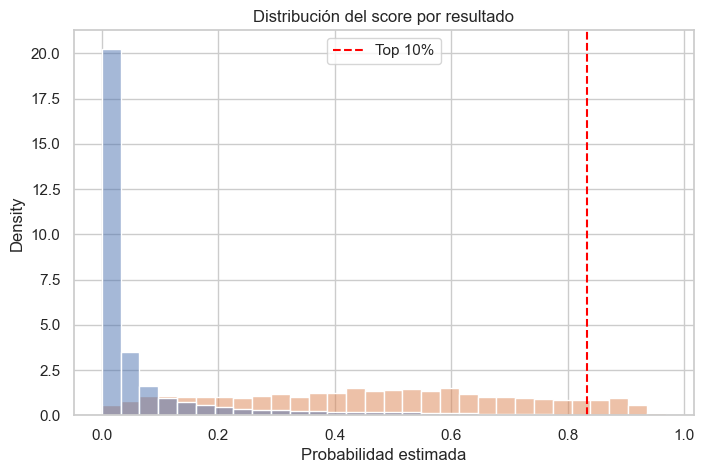

In [409]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_sim,
    x="score_oof",
    hue="y",
    bins=30,
    stat="density",
    common_norm=False
)
plt.axvline(threshold, color="red", linestyle="--", label="Top 10%")
plt.legend()
plt.title("Distribución del score por resultado")
plt.xlabel("Probabilidad estimada")
plt.show()


In [21]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [22]:
def main(dataframe,num_cols,cat_cols,target_col = "y",drop_cols=None):
    validacion(dataframe,num_cols,cat_cols)
    if drop_cols is not None:
        dataframe = dataframe.drop(columns=drop_cols, errors='ignore')
    
    plot_categorical_distribution(dataframe)
    plot_numeric_kde(dataframe)
    results = train_logit_cv_with_coefs(dataframe)
    print("Coeficiente regresion logistica")
    print("Top 10")
    display(results['coef_df'].head(10)  )
    print("Ultimos 10")
    display(results['coef_df'].tail(10)   )

Columnas coinciden: OK
No existen columnas con Null: OK


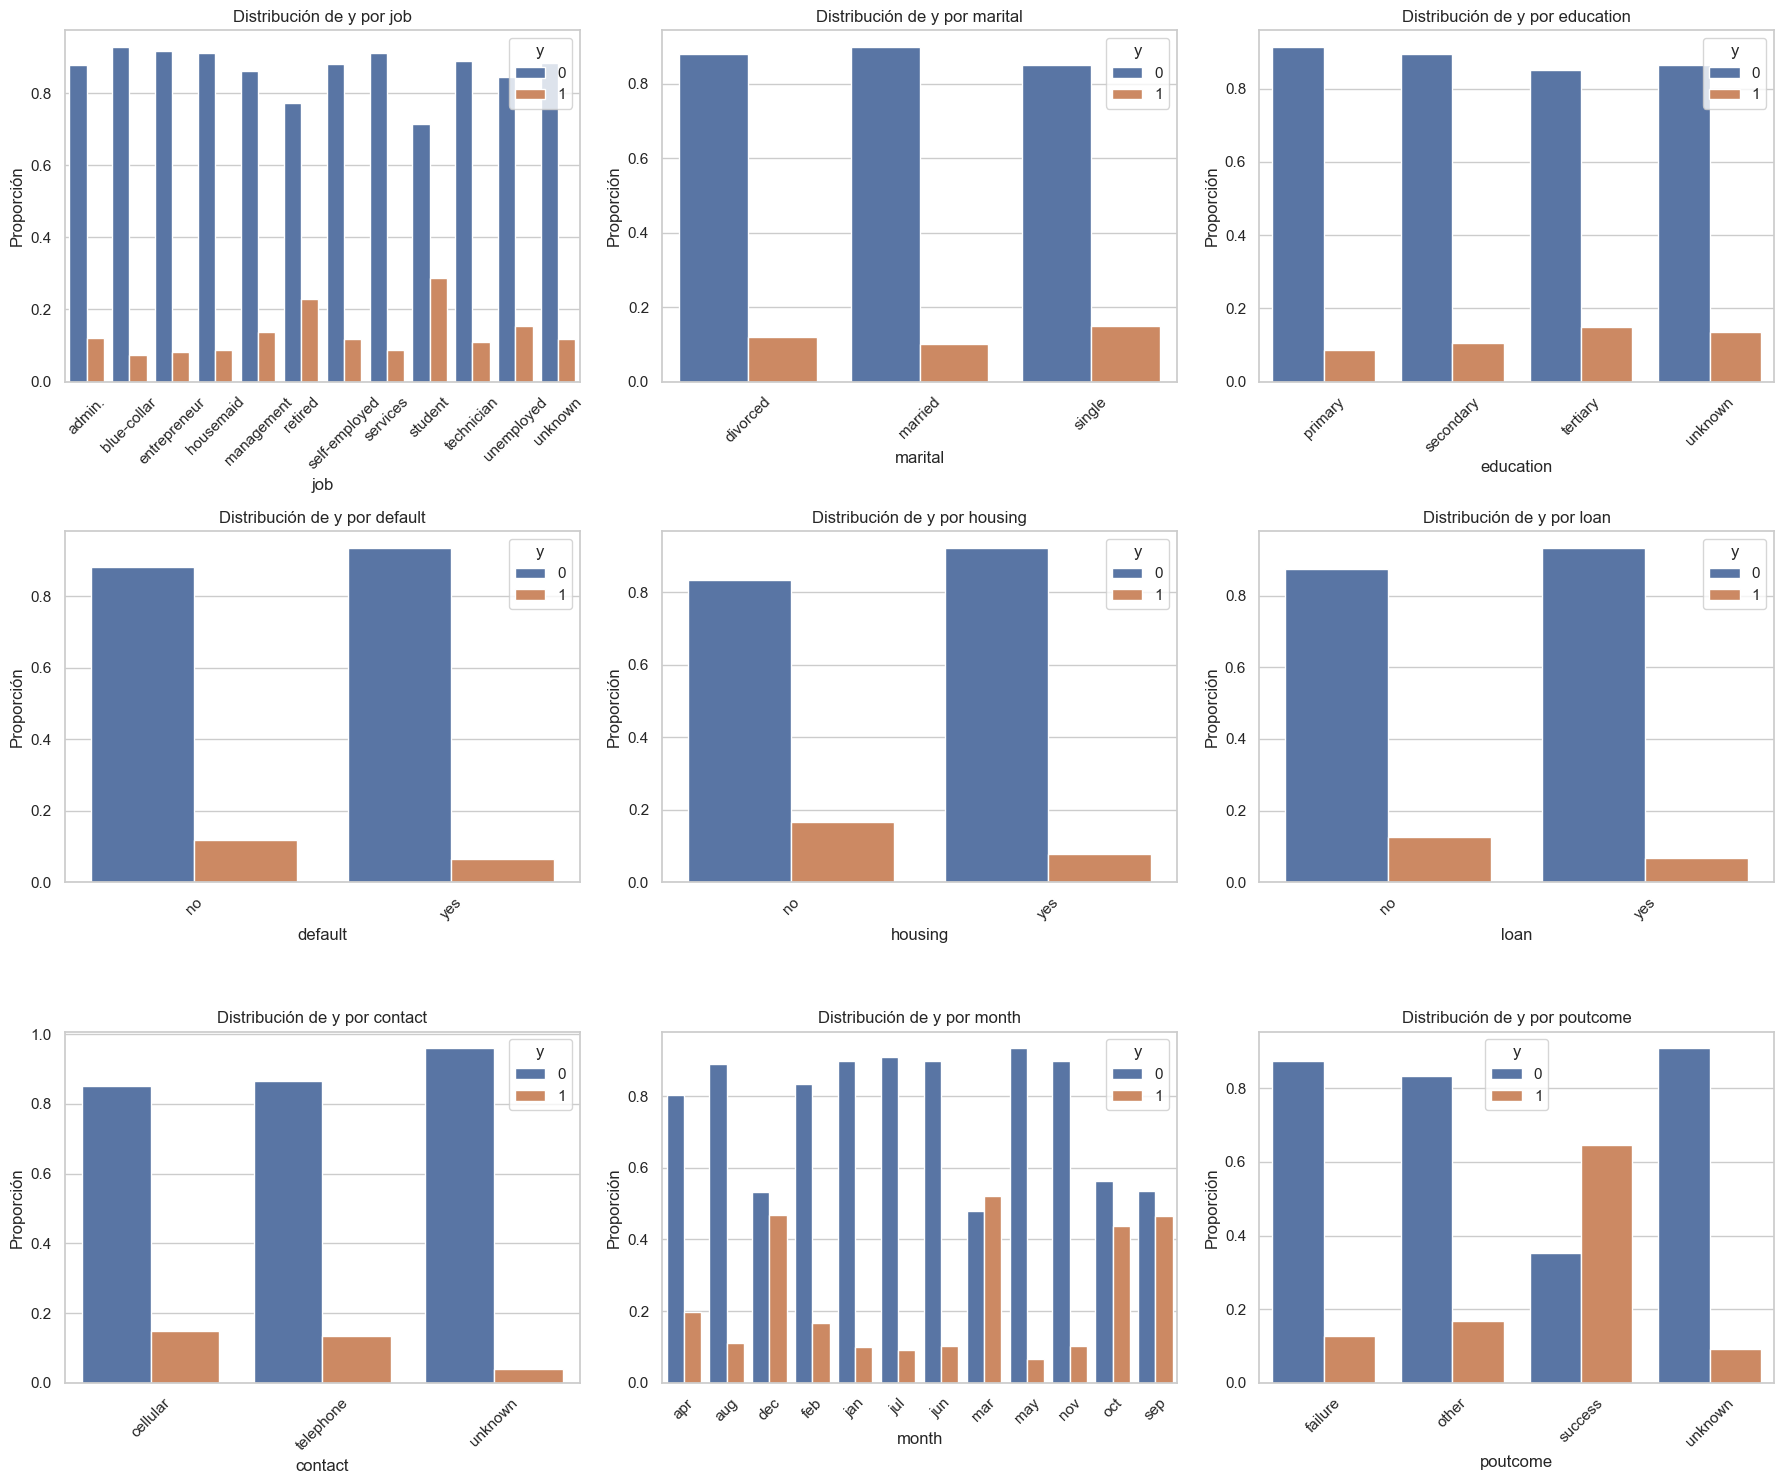

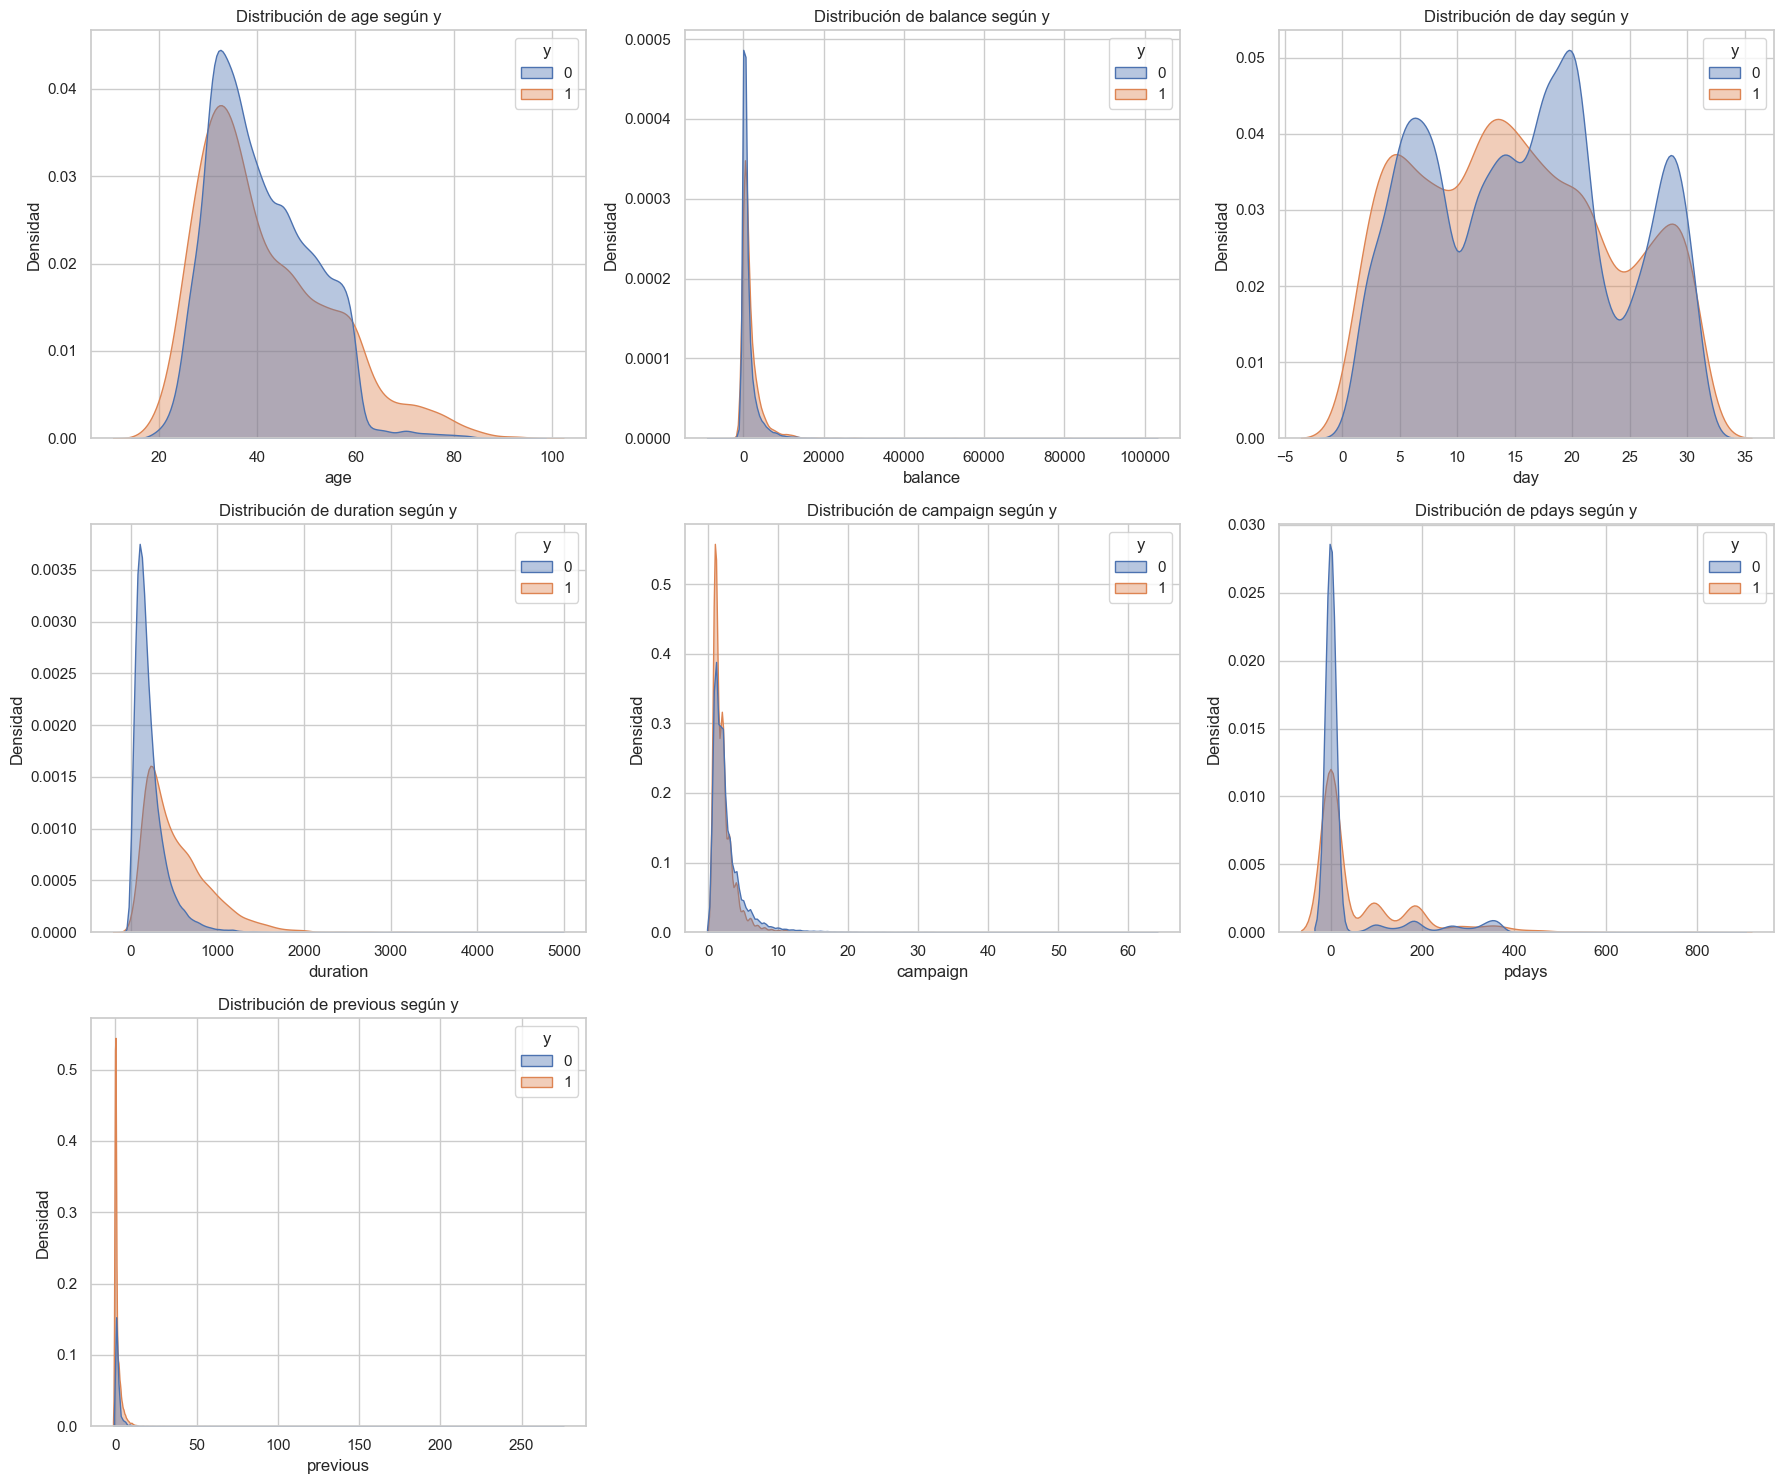

Coeficiente regresion logistica
Top 10


,feature,coef,odds_ratio
0,cat__month_mar,1.837700,6.282074
1,cat__poutcome_success,1.816004,6.147244
2,num__duration,1.510004,4.526750
3,cat__month_oct,1.253217,3.501589
4,cat__month_sep,0.983505,2.673810
5,cat__job_student,0.704490,2.022814
6,cat__month_dec,0.659323,1.933483
7,cat__contact_cellular,0.545596,1.725636
8,cat__contact_telephone,0.505509,1.657829
9,cat__job_retired,0.470998,1.601591


Ultimos 10


,feature,coef,odds_ratio
41,cat__poutcome_other,-0.378962,0.684571
42,cat__housing_yes,-0.396272,0.672824
43,cat__poutcome_failure,-0.603322,0.546992
44,cat__month_may,-0.702150,0.495519
45,cat__poutcome_unknown,-0.844273,0.429870
46,cat__month_aug,-0.881981,0.413962
47,cat__month_nov,-0.958155,0.383600
48,cat__contact_unknown,-1.061658,0.345882
49,cat__month_jul,-1.061971,0.345774
50,cat__month_jan,-1.295261,0.273826


In [23]:
main(df,num_cols,cat_cols,"y")

Columnas coinciden: OK
No existen columnas con Null: OK


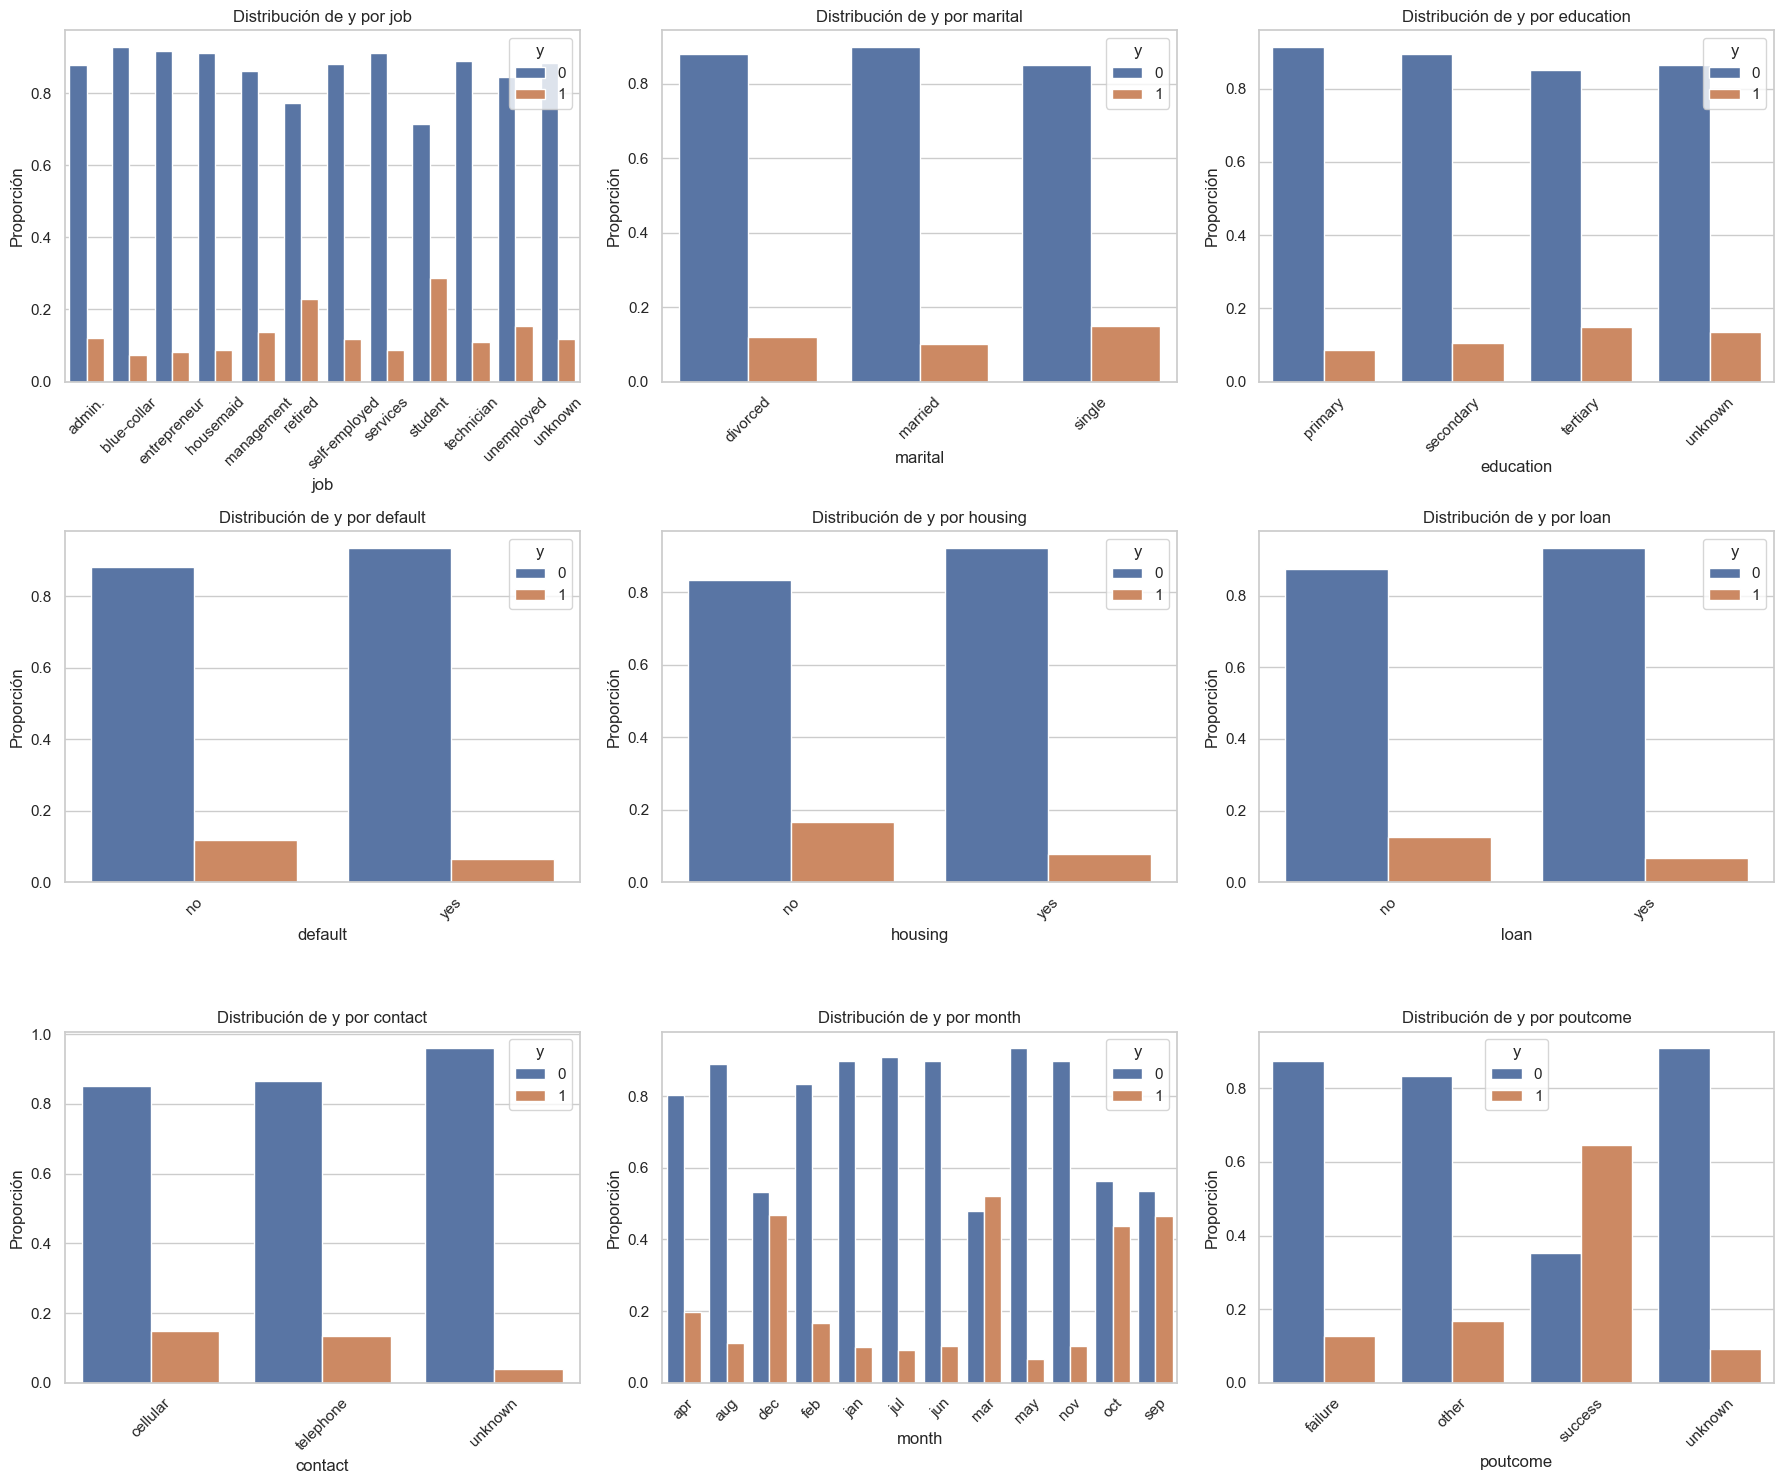

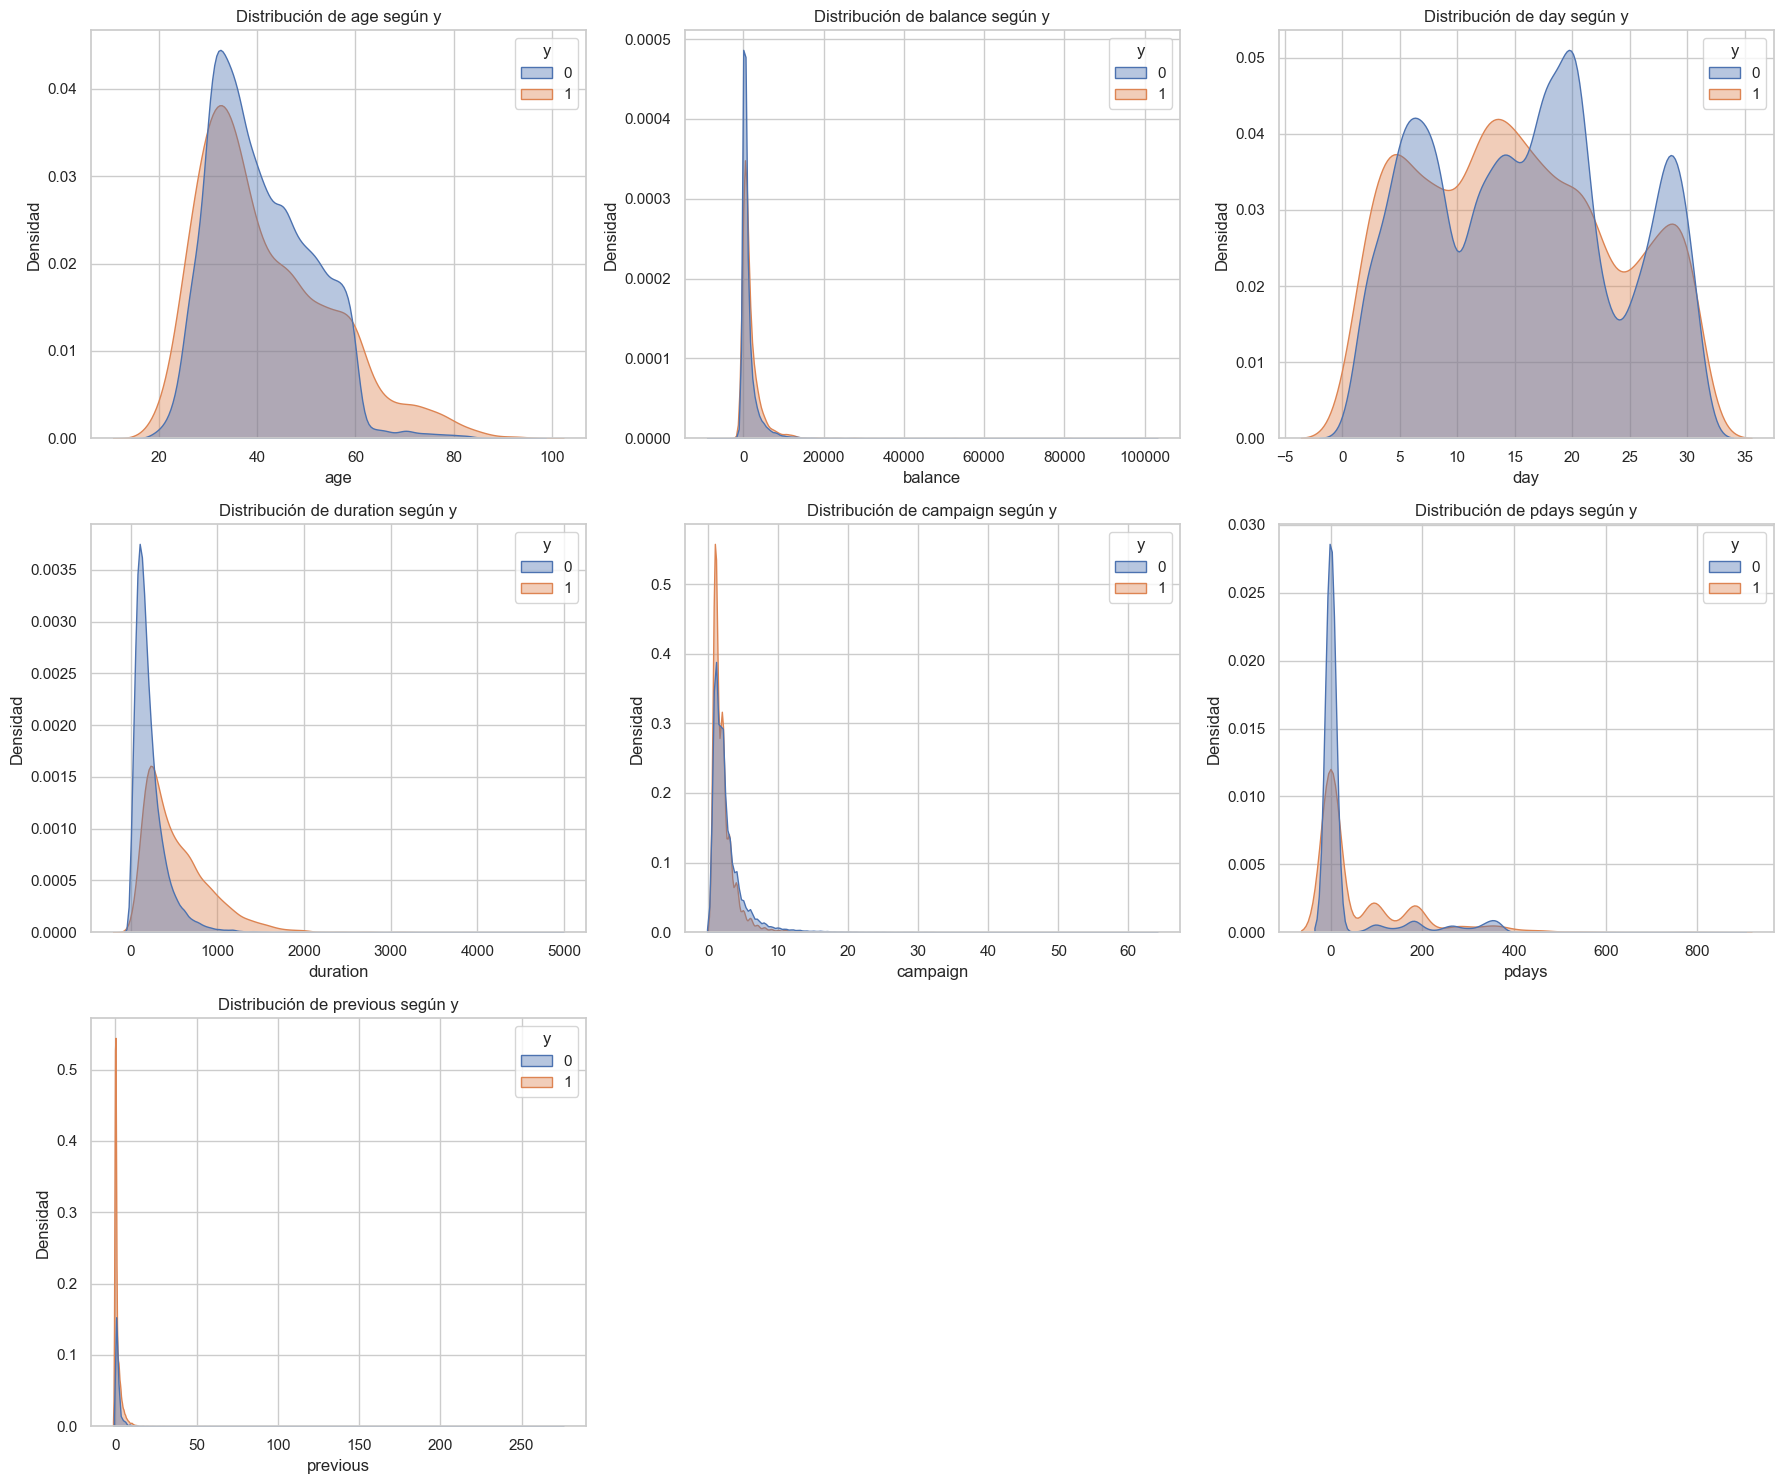

Coeficiente regresion logistica
Top 10


,feature,coef,odds_ratio
0,cat__month_mar,1.838,6.282
1,cat__poutcome_success,1.816,6.147
2,num__duration,1.510,4.527
3,cat__month_oct,1.253,3.502
4,cat__month_sep,0.984,2.674
5,cat__job_student,0.704,2.023
6,cat__month_dec,0.659,1.933
7,cat__contact_cellular,0.546,1.726
8,cat__contact_telephone,0.506,1.658
9,cat__job_retired,0.471,1.602


Ultimos 10


,feature,coef,odds_ratio
41,cat__poutcome_other,-0.379,0.685
42,cat__housing_yes,-0.396,0.673
43,cat__poutcome_failure,-0.603,0.547
44,cat__month_may,-0.702,0.496
45,cat__poutcome_unknown,-0.844,0.430
46,cat__month_aug,-0.882,0.414
47,cat__month_nov,-0.958,0.384
48,cat__contact_unknown,-1.062,0.346
49,cat__month_jul,-1.062,0.346
50,cat__month_jan,-1.295,0.274


In [366]:
main(df,num_cols,cat_cols,"y")

In [355]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,0
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0
